# Testing QSAR of Targets

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Picking a target.

In [2]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 11
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

Docking.

In [3]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5,
    **config_
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{dockstring_dir}/{target}',
    config=config
)

Designer.

In [4]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Generate molecules.

In [5]:
from tqdm.notebook import tqdm

# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck))
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

random_molecules = []
for _ in tqdm(range(20)):
    
    # pick a molecule randomly from the deck
    initial_molecule = select_molecule(deck)

    # generate a few rounds of random molecules in REAL Space
    molecule = initial_molecule
    designer.reset_cache()
    for _ in range(3):
        molecule = designer.design(molecule, 1, temperature=1.0)[0]
    
    # generate a bunch of analogs
    molecules = designer.design(molecule, 3, temperature=0.0)
    
    random_molecules.extend(molecules)

  0%|          | 0/20 [00:00<?, ?it/s]

Get results of docking.

In [15]:
import time
import numpy as np

t = time.time()

scores = []
for _ in tqdm(range(10)):
    scores.append(docking_oracle(random_molecules, use_cache=False))

print(time.time() - t)

ranks = np.argsort(-np.array(scores).T, axis=0).argsort(axis=0).T

  0%|          | 0/10 [00:00<?, ?it/s]

268.89517188072205


In [16]:
df.groupby('molecule').agg('std')['rank'].median()

0.14568888133127195

In [20]:
df.groupby('molecule').agg('std')['rank'].median()

0.12058273195030764

Text(0.5, 1.0, 'Repeat Boltzmann scores of molecules | n=10')

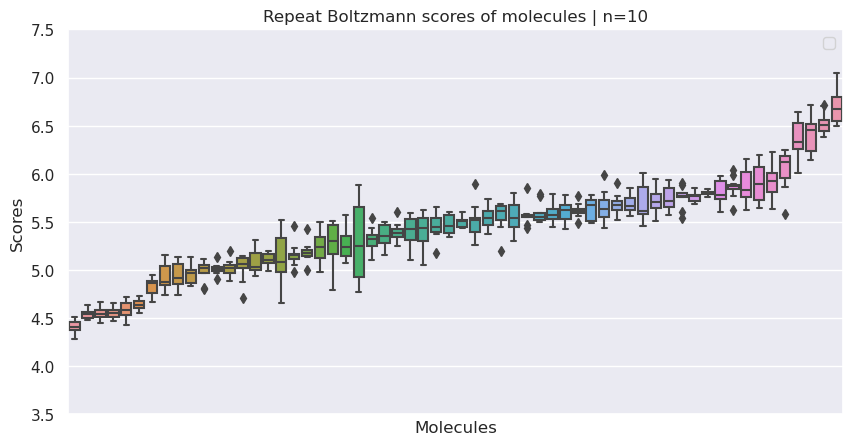

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.figure(figsize=(10, 5))

df = (
    pd.DataFrame(scores)
    .stack()
    .reset_index()
    .set_axis(['trial', 'molecule', 'rank'], axis=1)
)

molecules_sorted = (
    df
    .groupby('molecule')
    .agg('mean')['rank']
    .sort_values(ascending=True)
)

g = sns.boxplot(
    df,
    x='molecule',
    y='rank',
    order=molecules_sorted.index,
    # hue='molecule',
    # palette='colorblind'
)

plt.xticks([])
plt.legend([])
# g.axes.invert_yaxis()
plt.ylim(3.5, 7.5)
plt.ylabel('Scores')
plt.xlabel('Molecules')
plt.title('Repeat Boltzmann scores of molecules | n=10')

### Manual greedy loop

In [62]:
designer.reset_cache()
print(np.nanmax(docking_oracle(random_molecules)))

# 1
analogs_1 = designer.design(random_molecules[45], 30)
analog_scores = docking_oracle(analogs_1)
best = np.argmax(analog_scores)
print(np.nanmax(analog_scores))

# 2
analogs_2 = designer.design(analogs_1[best], 30)
analog_scores = docking_oracle(analogs_2)
best = np.argmax(analog_scores)
print(np.nanmax(analog_scores))

# 3
analogs_3 = designer.design(analogs_2[best], 30)
analog_scores = docking_oracle(analogs_3)
best = np.argmax(analog_scores)
print(np.nanmax(analog_scores))

6.185077246438812
6.986350565550311
6.824213958973099
6.56146579742163


In [75]:
docking_oracle(analogs_1[17])

TypeError: super(type, obj): obj must be an instance or subtype of type

In [69]:
[
    print(docking_oracle([analogs_1[17]], use_cache=False))
    for _ in range(10)
]

[6.3964338942983945]
[6.324775304784358]
[6.363137984019145]
[6.321156184101831]
[6.434796573533182]
[6.555675204329587]
[6.359518863336618]
[6.229954342902148]
[6.426834508031622]
[6.70695444885922]


[None, None, None, None, None, None, None, None, None, None]

In [25]:
[
    print(docking_oracle([analogs_3[best]], use_cache=False))
    for _ in range(10)
]

[5.213705255248539]
[5.652342681970823]
[5.776840433449755]
[5.81086016786551]
[5.626285013056628]
[4.954576214379598]
[6.465921011402915]
[5.904957305611214]
[5.647275913015284]
[5.783354850678304]


[None, None, None, None, None, None, None, None, None, None]

In [18]:
docking_oracle(designer.design(analogs_3[best], 10))

[5.658133275062866,
 5.744992171443517,
 6.270488494546452,
 5.298392679219673,
 6.0019497399029405,
 5.315764458495803,
 5.670438285383458,
 5.524225809809363,
 6.140923974111981,
 5.609637057917003]

In [14]:
docking_oracle(designer.design(analogs_3[best], 10, temperature=0.0), use_cache=False)

[5.677676526748513,
 5.304907096448221,
 5.6407614957867365,
 5.712420085300773,
 5.980235015807779,
 5.418547485879572,
 5.867318450512933,
 5.707353316345235,
 5.654514154380339,
 5.923776733160355]

In [240]:
# import time

# t = time.time()

# scores = []
# for _ in tqdm(range(30)):
#     scores.append(docking_oracle(designer.design(analogs_3[best], 10, temperature=0.0), use_cache=False))

# print(time.time() - t)

ranks = np.argsort(-np.array(scores).T, axis=0).argsort(axis=0).T

In [245]:
docking_oracle([analogs_3[best]])

['REMARK VINA RESULT:    -8.369      0.000      0.000\n', 'REMARK VINA RESULT:    -7.928      2.649      4.202\n', 'REMARK VINA RESULT:    -7.898      1.364      1.862\n', 'REMARK VINA RESULT:    -7.874      1.269      2.816\n', 'REMARK VINA RESULT:    -7.842      1.707      2.354\n', 'REMARK VINA RESULT:    -7.800      2.793      4.041\n', 'REMARK VINA RESULT:    -7.797      2.125      2.958\n', 'REMARK VINA RESULT:    -7.694      2.217      3.616\n', 'REMARK VINA RESULT:    -7.615      1.032      1.040\n']


[6.057684198413858]

Text(0.5, 1.0, 'Repeat scores of molecules | n=10')

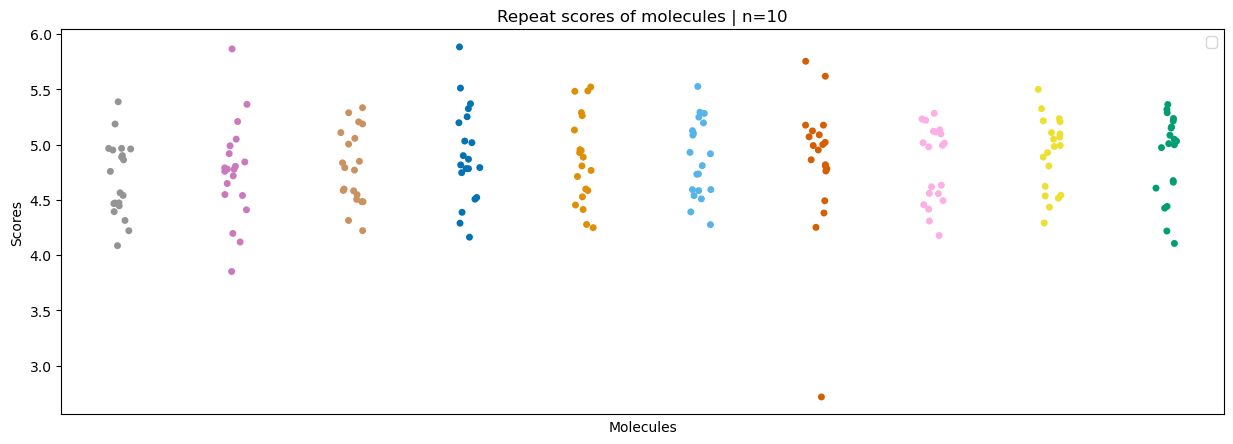

In [241]:
import pandas as pd

plt.figure(figsize=(15, 5))

df = (
    pd.DataFrame(scores)
    .stack()
    .reset_index()
    .set_axis(['trial', 'molecule', 'rank'], axis=1)
)

molecules_sorted = (
    df
    .groupby('molecule')
    .agg('median')['rank']
    .sort_values(ascending=True)
)

g = sns.stripplot(
    df,
    x='molecule',
    y='rank',
    order=molecules_sorted.index,
    hue='molecule',
    palette='colorblind'
)

plt.xticks([])
plt.legend([])
# g.axes.invert_yaxis()
plt.ylabel('Scores')
plt.xlabel('Molecules')
plt.title('Repeat scores of molecules | n=10')

### Look at inter- vs. intra-cluster variation

In [119]:
import numpy as np

chunks = np.array_split(random_molecules, 20)
cluster_stds = [np.nanstd(docking_oracle(chunk)) for chunk in chunks]
mean_cluster_std = np.nanmean(cluster_stds)
mean_std = np.nanstd(scores)
print('Within Cluster:', mean_cluster_std,
      '\nBetween Cluster:', mean_std)

Within Cluster: 0.44947915669424293 
Between Cluster: 1.8158983126056485


### Compare pairwise fingerprints and affinity

In [133]:
import chemfp

self = designer.generator

fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in random_molecules
]

queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries=queries,
    targets=queries,
    threshold=0.0,
    include_lower_triangle=False,
)

similarity = results.to_pandas()
similarity_matrix = results.to_csr().A

queries:   0%|                            | 0/100 [00:00<?, ? fps/s]

Get affinity score differences.

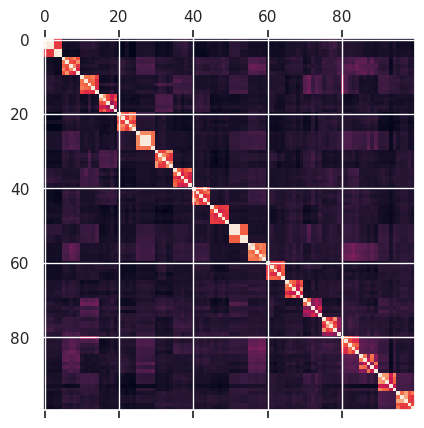

In [134]:
import numpy as np
from sklearn.metrics.pairwise import nan_euclidean_distances

# Convert the list of floats to a 2D numpy array with one column
float_array = np.array(scores).reshape(-1, 1)

# Calculate pairwise distances using the default metric (Euclidean)
distances = nan_euclidean_distances(float_array)

import matplotlib.pyplot as plt
plt.matshow(similarity_matrix)

In [112]:
np.nanquantile(abs(distances).ravel(), 0.9)

1.405117357350956

Text(0.5, 1.0, 'Correlation of Docking and Fingerprint Similarity')

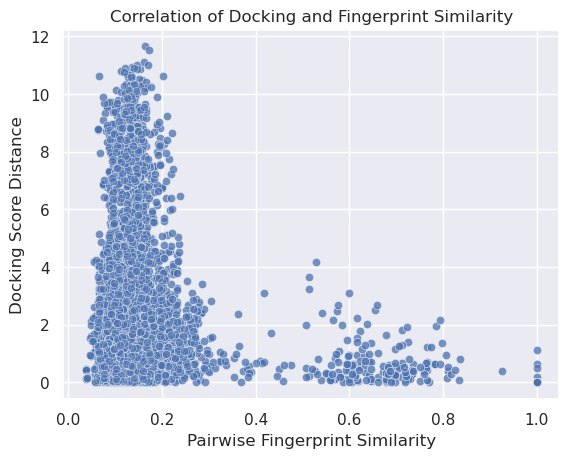

In [135]:
sns.set()
g = sns.scatterplot(
    x=similarity_matrix.ravel(),
    y=abs(distances).ravel(),
    alpha=0.5
)

plt.xlabel('Pairwise Fingerprint Similarity')
plt.ylabel('Docking Score Distance')
plt.title('Correlation of Docking and Fingerprint Similarity')

Seeing if being similar to high affinity molecules predicts high affinity.

In [136]:
best = np.argsort(scores)[-10:]
best_molecules = dg.collection.Collection(random_molecules)[best]

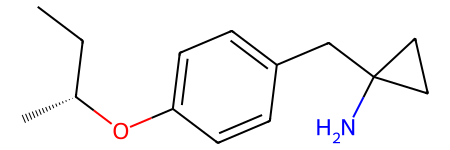

In [138]:
random_molecules[4]

In [139]:
import chemfp

self = designer.generator

fingerprint_type = self.fingerprints.get_fingerprint_type()
fingerprints = [
    (m.name, fingerprint_type.from_smi(m.smiles))
    for m in best_molecules
]

best_queries = chemfp.load_fingerprints(
    fingerprints,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

results = chemfp.simsearch(
    queries=best_queries,
    targets=queries,
    k=5,
    include_lower_triangle=False,
)

queries:   0%|                             | 0/10 [00:00<?, ? fps/s]

In [140]:
# mols = results.to_pandas()['target_id'].tolist()
nearest_scores = [
    scores[i]
    for index in results.iter_indices()
    for i in index
    if i not in best
]

np.nanmean(nearest_scores)

7.1450821199643455